In [8]:
!pip install gdown
import gdown
import gdown
import zipfile
import os
url = 'https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr'
output_path = 'large_file.hdf5'
gdown.download(url, output_path, quiet=False)
import matplotlib.pyplot as plt
import numpy as np
import h5py
with h5py.File('large_file.hdf5', 'r') as file:
    train_imgs = np.array(file['X_jets'][:4096])
    test_imgs = np.array(file['X_jets'][4096:4096+1024])
    train_labels = np.array(file['y'][:4096])
    test_labels = np.array(file['y'][4096:4096+1024])
    print(train_imgs[0].shape)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms

Downloading...
From (original): https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr
From (redirected): https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr&confirm=t&uuid=2c077029-8f9a-41c5-9aef-67ad45acf880
To: /kaggle/working/large_file.hdf5
100%|██████████| 701M/701M [00:06<00:00, 107MB/s]  


(125, 125, 3)


torch.Size([64, 3, 16, 16])
torch.Size([64])


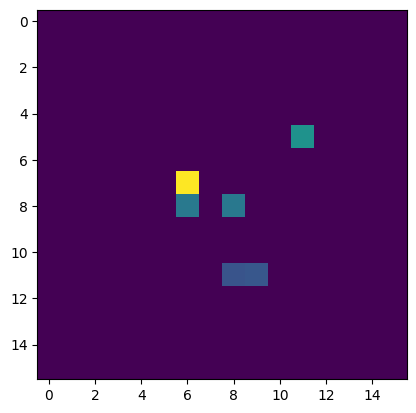

In [9]:
class Data(torch.utils.data.Dataset):
    def __init__(self,imgs,labels):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((16, 16))###smaller size for efficient processing in ViT
            #transforms.Normalize([0.,0.,0.],[1.,1.,1.]),
        ])
        self.imgs = imgs
        self.labels = labels
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self,idx):
        img = self.transform(self.imgs[idx])
        return img,torch.tensor(self.labels[idx]).to(torch.long)

train_loader = torch.utils.data.DataLoader(Data(train_imgs,train_labels), batch_size=64)
val_loader = torch.utils.data.DataLoader(Data(test_imgs,test_labels), batch_size=64)

for imgs,labels in train_loader:
    print(imgs.shape)
    img = imgs[0]
    plt.imshow(img.permute(1,2,0).cpu().numpy()[:,:,2])
    print(labels.shape)
    break

## Vision Transformer for Classification

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Define the ViT model
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        self.patch_embeddings = nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim),
            num_layers=depth
        )
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embeddings(x)
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embeddings
        x = self.transformer(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        return x

# Define the hyperparameters
image_size = 16
patch_size = 2
num_classes = 2  # Replace with the number of classes in your dataset
dim = 768
depth = 2
heads = 4
mlp_dim = 256
channels = 3
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
accuracies = []
# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    val_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    losses.append(val_loss)
    accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/10: 100%|██████████| 64/64 [00:03<00:00, 20.90it/s]


Epoch 1/10, Train Loss: 1.4376, Val Loss: 0.6939, Val Accuracy: 0.4736


Epoch 2/10: 100%|██████████| 64/64 [00:02<00:00, 21.53it/s]


Epoch 2/10, Train Loss: 0.7261, Val Loss: 0.6933, Val Accuracy: 0.4736


Epoch 3/10: 100%|██████████| 64/64 [00:03<00:00, 21.26it/s]


Epoch 3/10, Train Loss: 0.7236, Val Loss: 0.6934, Val Accuracy: 0.5264


Epoch 4/10: 100%|██████████| 64/64 [00:02<00:00, 21.64it/s]


Epoch 4/10, Train Loss: 0.7223, Val Loss: 0.6942, Val Accuracy: 0.5264


Epoch 5/10: 100%|██████████| 64/64 [00:02<00:00, 21.53it/s]


Epoch 5/10, Train Loss: 0.7035, Val Loss: 0.6934, Val Accuracy: 0.5264


Epoch 6/10: 100%|██████████| 64/64 [00:03<00:00, 21.24it/s]


Epoch 6/10, Train Loss: 0.7033, Val Loss: 0.6975, Val Accuracy: 0.4736


Epoch 7/10: 100%|██████████| 64/64 [00:02<00:00, 21.54it/s]


Epoch 7/10, Train Loss: 0.6997, Val Loss: 0.6942, Val Accuracy: 0.4736


Epoch 8/10: 100%|██████████| 64/64 [00:03<00:00, 20.74it/s]


Epoch 8/10, Train Loss: 0.6981, Val Loss: 0.6928, Val Accuracy: 0.5264


Epoch 9/10: 100%|██████████| 64/64 [00:02<00:00, 21.34it/s]


Epoch 9/10, Train Loss: 0.6971, Val Loss: 0.6918, Val Accuracy: 0.5264


Epoch 10/10: 100%|██████████| 64/64 [00:02<00:00, 21.49it/s]


Epoch 10/10, Train Loss: 0.6963, Val Loss: 0.6923, Val Accuracy: 0.5264


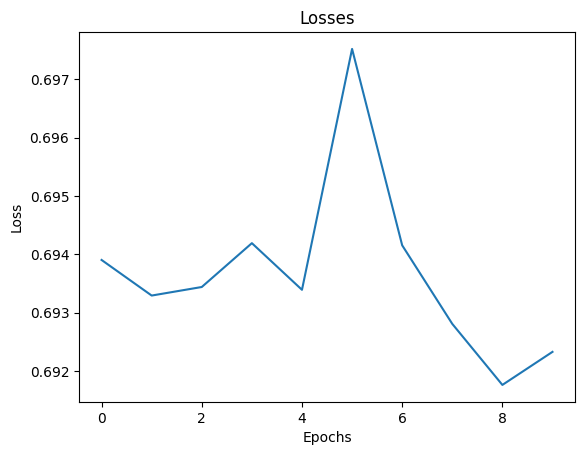

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


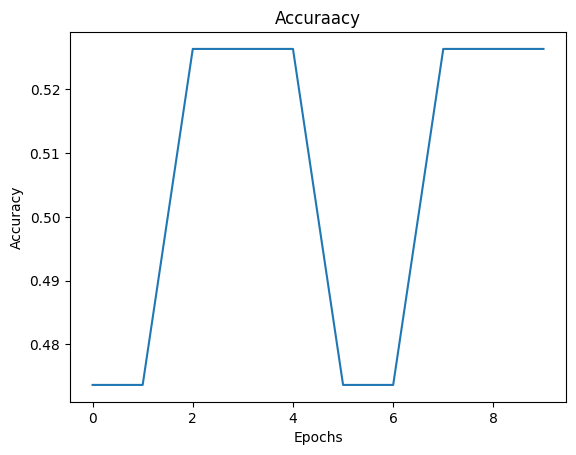

In [16]:
plt.plot(accuracies)
plt.title("Accuraacy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [17]:
del model
torch.cuda.empty_cache()

## Vision Transformer for Image generation with Convolution Decoder

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Define the ViT model with encoder-decoder architecture
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        self.patch_embeddings = nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        # Encoder
        self.encoder_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim),
            num_layers=depth
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim, dim // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(dim // 2, dim // 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(dim // 4, dim // 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(dim // 8, channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Encoder
        x_enc = self.patch_embeddings(x)
        x_enc = x_enc.flatten(2).transpose(1, 2)
        cls_tokens_enc = self.cls_token.expand(B, -1, -1)
        x_enc = torch.cat((cls_tokens_enc, x_enc), dim=1)
        x_enc += self.pos_embeddings
        x_enc = self.encoder_transformer(x_enc)
        x_enc = x_enc[:, 0]  # Take the first token

        # Decoder
        x_dec = x_enc.unsqueeze(-1).unsqueeze(-1)  # Add spatial dimensions
        x_dec = self.decoder(x_dec)
        return x_dec

# Define the hyperparameters
image_size = 16
patch_size = 1
num_classes = 2  # For RGB images
dim = 64
depth = 1
heads = 2
mlp_dim = 64
channels = 3  # For RGB images
batch_size = 128
learning_rate = 0.0001
num_epochs = 20

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Use Mean Squared Error for image generation
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)  # Compare generated images with ground truth
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation loop
    val_loss = 0.0
    model.eval()
    for images, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)  # Compare generated images with ground truth
        val_loss += loss.item()
    val_loss /= len(val_loader)
    losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/20: 100%|██████████| 16/16 [00:00<00:00, 55.88it/s]


Epoch 1/20, Train Loss: 0.2497, Val Loss: 0.2452


Epoch 2/20: 100%|██████████| 16/16 [00:00<00:00, 54.67it/s]


Epoch 2/20, Train Loss: 0.2175, Val Loss: 0.1623


Epoch 3/20: 100%|██████████| 16/16 [00:00<00:00, 55.95it/s]


Epoch 3/20, Train Loss: 0.0994, Val Loss: 0.0530


Epoch 4/20: 100%|██████████| 16/16 [00:00<00:00, 54.74it/s]


Epoch 4/20, Train Loss: 0.0363, Val Loss: 0.0241


Epoch 5/20: 100%|██████████| 16/16 [00:00<00:00, 54.38it/s]


Epoch 5/20, Train Loss: 0.0186, Val Loss: 0.0135


Epoch 6/20: 100%|██████████| 16/16 [00:00<00:00, 54.02it/s]


Epoch 6/20, Train Loss: 0.0107, Val Loss: 0.0080


Epoch 7/20: 100%|██████████| 16/16 [00:00<00:00, 44.59it/s]


Epoch 7/20, Train Loss: 0.0065, Val Loss: 0.0050


Epoch 8/20: 100%|██████████| 16/16 [00:00<00:00, 54.46it/s]


Epoch 8/20, Train Loss: 0.0043, Val Loss: 0.0034


Epoch 9/20: 100%|██████████| 16/16 [00:00<00:00, 53.08it/s]


Epoch 9/20, Train Loss: 0.0030, Val Loss: 0.0025


Epoch 10/20: 100%|██████████| 16/16 [00:00<00:00, 55.39it/s]


Epoch 10/20, Train Loss: 0.0022, Val Loss: 0.0019


Epoch 11/20: 100%|██████████| 16/16 [00:00<00:00, 54.44it/s]


Epoch 11/20, Train Loss: 0.0017, Val Loss: 0.0015


Epoch 12/20: 100%|██████████| 16/16 [00:00<00:00, 54.36it/s]


Epoch 12/20, Train Loss: 0.0014, Val Loss: 0.0012


Epoch 13/20: 100%|██████████| 16/16 [00:00<00:00, 56.07it/s]


Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010


Epoch 14/20: 100%|██████████| 16/16 [00:00<00:00, 55.43it/s]


Epoch 14/20, Train Loss: 0.0009, Val Loss: 0.0008


Epoch 15/20: 100%|██████████| 16/16 [00:00<00:00, 51.25it/s]


Epoch 15/20, Train Loss: 0.0008, Val Loss: 0.0007


Epoch 16/20: 100%|██████████| 16/16 [00:00<00:00, 54.65it/s]


Epoch 16/20, Train Loss: 0.0007, Val Loss: 0.0006


Epoch 17/20: 100%|██████████| 16/16 [00:00<00:00, 55.57it/s]


Epoch 17/20, Train Loss: 0.0006, Val Loss: 0.0005


Epoch 18/20: 100%|██████████| 16/16 [00:00<00:00, 54.79it/s]


Epoch 18/20, Train Loss: 0.0005, Val Loss: 0.0005


Epoch 19/20: 100%|██████████| 16/16 [00:00<00:00, 57.17it/s]


Epoch 19/20, Train Loss: 0.0005, Val Loss: 0.0004


Epoch 20/20: 100%|██████████| 16/16 [00:00<00:00, 54.49it/s]

Epoch 20/20, Train Loss: 0.0004, Val Loss: 0.0004


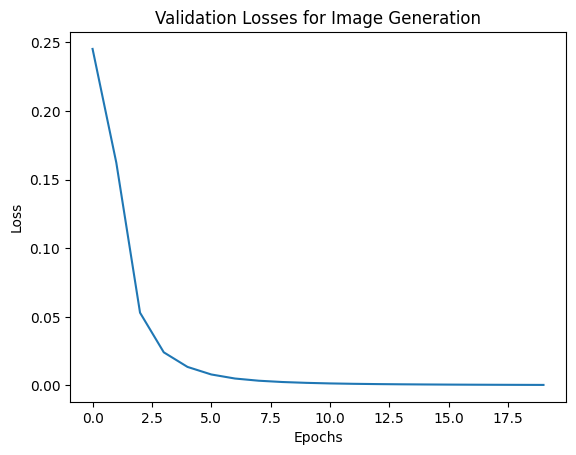

In [20]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Validation Losses for Image Generation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


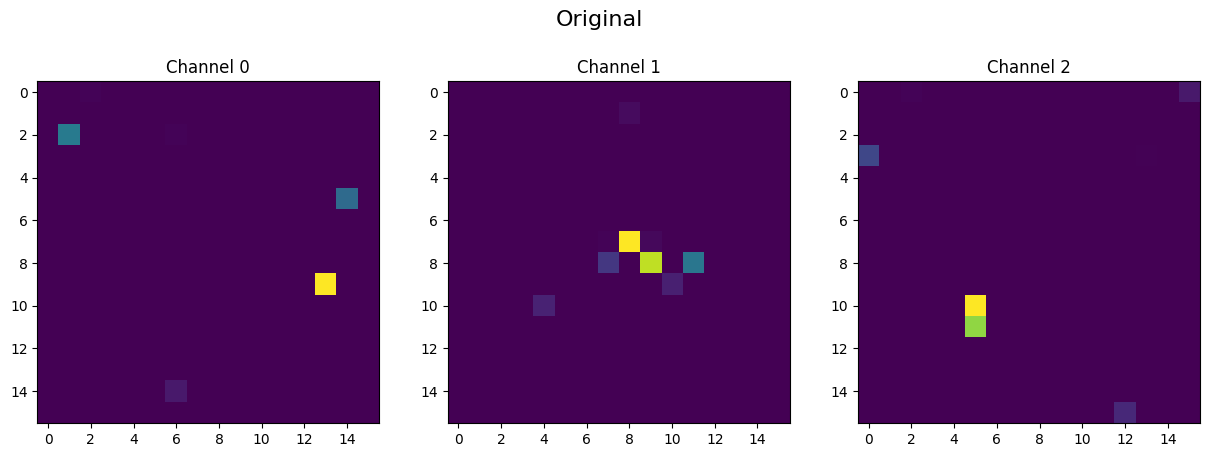

In [23]:
import random
model.eval()
r = random.randint(0,1024)
dataset = Data(test_imgs,test_labels)
imgorig = dataset[r][0]
imgrecons = model(imgorig.unsqueeze(0).to(device))
# print(np.array(imgrecons.cpu()).shape)
pltorig = imgorig.permute(1,2,0).cpu().numpy()
pltrecons = imgrecons.permute(0,2,3,1).detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(pltorig[:,:,0])
axs[0].set_title('Channel 0')

axs[1].imshow(pltorig[:,:,1])
axs[1].set_title('Channel 1')

axs[2].imshow(pltorig[:,:,2])
axs[2].set_title('Channel 2')

plt.suptitle('Original', fontsize=16)  # Set a common title for all subplots in the x-axis direction
plt.show()


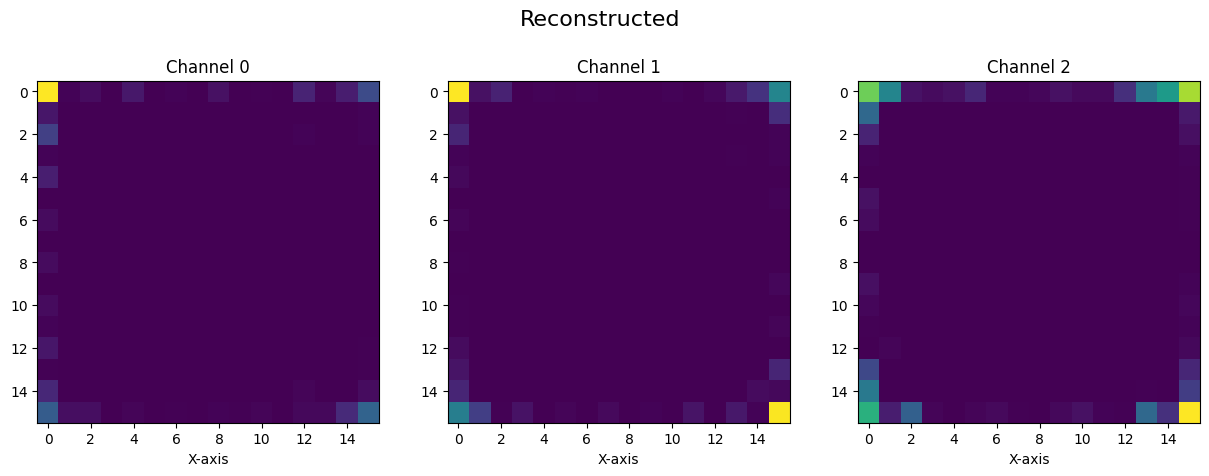

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(pltrecons[:,:,0])
axs[0].set_title('Channel 0')
axs[0].set_xlabel('X-axis')

axs[1].imshow(pltrecons[:,:,1])
axs[1].set_title('Channel 1')
axs[1].set_xlabel('X-axis')

axs[2].imshow(pltrecons[:,:,2])
axs[2].set_title('Channel 2')
axs[2].set_xlabel('X-axis')

plt.suptitle('Reconstructed', fontsize=16)  # Set a common title for all subplots in the x-axis direction
plt.show()
